# Modifying 2017 Geohackweek raster tutorial to use rasterio and cloud storage

https://geohackweek.github.io/raster


In particular, re-doing section4, to work with rasterio
https://geohackweek.github.io/raster/04-workingwithrasters/

## Working with raster datasets

questions:
  - "How can I extract pixel values from rasters and perform computations?"
  - "How might I write pixel values out to a new raster file?"

objectives:
  - "Understand the basic components of a raster dataset and how to access them from a python program."
  - "Perform numerical operations on pixel values."
  - "Read from and write to raster datasets."

keypoints:
  - "Rasterio is built around the GDAL library (recall section 3), to facilitate raster operations in Python."
  - "Pixel values of rasters can be extracted to a numpy array."
  - "Computation is done in local memory on numpy arrays, then saved to the raster format of choice."

# 1. Background

[GDAL](https://en.wikipedia.org/wiki/GDAL) is a powerful and mature library for reading, writing and warping raster datasets, written in C++ with bindings to other languages. There are a variety of geospatial libraries available on the python package index, and almost all of them depend
on GDAL.  One such python library developed and supported by Mapbox, ``rasterio``, builds on top of GDAL's many features, but provides a more pythonic interface and supports many of the features and formats that GDAL supports. Both GDAL and rasterio are constantly being updated and improved: As of writing this tutorial (July 2018), GDAL is at version 2.3.1 and rasterio is at version 1.0.2.

**When should you use GDAL directly?**
* If you are comfortable with the terminal, [GDAL's command line utilities](https://www.gdal.org/gdal_utilities.html) are very useful for scripting.
* Note that GDAL also has auto-generated [Python bindings](https://pypi.org/project/GDAL/), but we recommend using rasterio instead!

**When should you use ``rasterio`` instead of GDAL?**
* Maybe always?! Rasterio also has a set of command line tools 
* If you are working in a Python environment (ipython, scripts, jupyter lab)

**When might these not be the best tools?**
* Both libraries are critical for input/output operations, but you'll draw on other libraries for computation (e.g. numpy)
    * That said, GDAL does have some standard processing scripts (for example [pan-sharpening](https://www.gdal.org/gdal_pansharpen.html)) and rasterio provides a [plugin interface](https://github.com/mapbox/rasterio/wiki/Rio-plugin-registry) for workflows
* For polished map creation and interactive visualization, a desktop GIS software like [QGIS](https://qgis.org/en/site/) may be a better, more fully-featured choice.


# 2. Loading and viewing Landsat 8 imagery

The Landsat program is the longest-running satellite imagery program, with the first satellite launched in 1972. Landsat 8 is the latest satellite in this program, and was launched in 2013. Landsat observations are processed into “scenes”, each of which is approximately 183 km x 170 km, with a temporal resolution of 16 days. The duration of the landsat program makes it an attractive source of medium-scale imagery for land surface change analyses. Landsat is multiband imagery, you can read more about it [here](https://landsat.usgs.gov).

One reason we'll use Landsat 8 for this demo is that the entire Landsat 8 archive is hosted by various commercial Cloud providers (AWS, Google Cloud), for free! Furthermore, [these archives](https://registry.opendata.aws/landsat-8/) use a new image format know as [Cloud-optimized Geotiffs (COGs)](http://www.cogeo.org), to allow easy access to full files or subsets of files from your local computer.

We'll start with simply examining a single image acquired over California in summer, 2017. Landsat images are organized by 'path' and 'row', and AWS has put together a simple webpage for browsing the archive called ["Landsat on AWS"](https://landsatonaws.com). To see all the acquisition dates for a particular path and row:

https://landsatonaws.com/L8/042/034
    
    
We'll pick a scene with low cloud cover (LC08_L1TP_042034_20170616_20170629_01_T1). Note that 'T1' stands for 'Tier 1' (for analytic use), and 'RT' stands for 'Real-time', for which quality control is not as rigorous. Read more about the various Landsat formats and collections [here](https://landsat.usgs.gov/landsat-collections). So we have the following link to the acquisition landing page that has addition links to metadata and full resolution imagery files:

https://landsatonaws.com/L8/042/034/LC08_L1TP_042034_20170616_20170629_01_T1    


For example, the band 4 image is stored at:

http://landsat-pds.s3.amazonaws.com/c1/L8/042/034/LC08_L1TP_042034_20170616_20170629_01_T1/LC08_L1TP_042034_20170616_20170629_01_T1_B4.TIF

In [1]:
import rasterio
import rasterio.plot
import pyproj
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

print('rasterio version: ', rasterio.__version__)
print('pyproj version: ', pyproj.__version__)
print('matplotlib version: ', matplotlib.__version__)
print('numpy version: ', np.__version__)

%matplotlib inline

rasterio version:  1.0.2
pyproj version:  1.9.5.1
matplotlib version:  2.2.2
numpy version:  1.14.2


In [2]:
filepath = 'http://landsat-pds.s3.amazonaws.com/c1/L8/042/034/LC08_L1TP_042034_20170616_20170629_01_T1/LC08_L1TP_042034_20170616_20170629_01_T1_B4.TIF'
with rasterio.open(filepath) as src:
    print(src.profile)

{'driver': 'GTiff', 'dtype': 'uint16', 'nodata': None, 'width': 7821, 'height': 7951, 'count': 1, 'crs': CRS({'init': 'epsg:32611'}), 'transform': Affine(30.0, 0.0, 204285.0,
       0.0, -30.0, 4268115.0), 'blockxsize': 512, 'blockysize': 512, 'tiled': True, 'compress': 'deflate', 'interleave': 'band'}


### What just happend?

If you’re familiary with programming in python, you’ve probably seen context managers before. This context manager, **rasterio.open()** functions like the python standard library function open for opening files. The block of code within the with ... as statement is executed once the file is opened, and the file is closed when the context manager exits. This means that we don’t have to manually close the raster file, as the context manager handles that for us.

Instead of a local file path, rasterio knows how to read URLs too, so we just passed the link to the file on AWS

**src.profile** is a collection of metadata for the file. We see that it is a Geotiff (Gtiff), the image values are unsigned integer format, nodata values are not assigned, the image has a dimensions of 7711x7531, is a single band, is in [UTM coordinates](http://www.spatialreference.org/ref/epsg/wgs-84-utm-zone-11n), has a simple affine transformation, is chunked into smaller 512x512 arrays, tiled and compressed on the AWS hard drive where it is stored.

Note that we have not actually downloaded the image! It's full size is about 60Mb. But one nice aspect of the COG format is that we can easily grab downsampled versions of the full image for quick visualization:

Decimation factor= 81
array type:  <class 'numpy.ndarray'>
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


Text(0,0.5,'Row #')

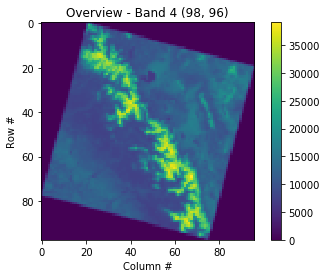

In [3]:
# The grid of raster values can be accessed as a numpy array and plotted:
with rasterio.open(filepath) as src:
    oviews = src.overviews(1) # list of overviews from biggest to smallest
    oview = oviews[-1] # let's look at the smallest thumbnail
    print('Decimation factor= {}'.format(oview))
    # NOTE this is using a 'decimated read' (http://rasterio.readthedocs.io/en/latest/topics/resampling.html)
    thumbnail = src.read(1, out_shape=(1, int(src.height // oview), int(src.width // oview)))
    
print('array type: ',type(thumbnail))
print(thumbnail)
    
plt.imshow(thumbnail)
plt.colorbar()
plt.title('Overview - Band 4 {}'.format(thumbnail.shape))
plt.xlabel('Column #')
plt.ylabel('Row #')

Earlier we saw in the metadata that a no-data value wasn't set, but pixels outside the imaged area are clearly set to "0". Images commonly look like this because of satellite orbits and the fact that the Earth is rotating as imagery is acquired! The colormap is often improved if we change the out of bounds area to NaN. To do this we have to convert the datatype from uint16 to float32 (so be aware the array with NaNs will take 2x the storage space). The serrated edge is due to the coarse sampling of the full resolution image that we are doing here

Decimation factor= 81


Text(0,0.5,'Row #')

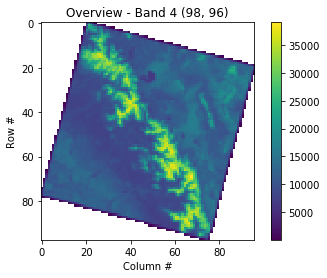

In [4]:
with rasterio.open(filepath) as src:
    oviews = src.overviews(1) 
    oview = oviews[-1]
    print('Decimation factor= {}'.format(oview))
    thumbnail = src.read(1, out_shape=(1, int(src.height // oview), int(src.width // oview)))
    
    thumbnail = thumbnail.astype('f4')
    thumbnail[thumbnail==0] = np.nan
    
plt.imshow(thumbnail)
plt.colorbar()
plt.title('Overview - Band 4 {}'.format(thumbnail.shape))
plt.xlabel('Column #')
plt.ylabel('Row #')

# 3. Example computation: NDVI

The [Normalized Difference Vegetation
Index](https://en.wikipedia.org/wiki/Normalized_Difference_Vegetation_Index) is a simple indicator that can be used to assess whether the target includes healthy vegetation.   This calculation uses two bands of a multispectral image dataset, the Red and Near-Infrared (NIR) bands:

$$NDVI = \frac{(NIR - Red)}{(NIR + Red)}$$

For this tutorial, we'll use the NIR and Red bands from a Landsat-8 scene above part of the central valley and the Sierra Nevada in California.  We'll be using [Level 1TP datasets](https://landsat.usgs.gov/landsat-processing-details), orthorectified, map-projected images containing radiometrically calibrated data. 

### Bands

* Red: Band 4 
* Near-Infrared: Band 5

Because of the longevity of the landsat mission and because different sensors on the satellite record data at different resolutions, these bands are individually stored as single-band raster files.  Some other rasters may store multiple bands in the same file.

NB: Full resolution Landsat scenes are distributed with a 30m pixel resolution. For the sake of this tutorial and the computational time on our jupyterhub instance, we will use downsampled overviews

In [5]:
# Use the same example image:
date = '2017-06-16'
url = 'http://landsat-pds.s3.amazonaws.com/c1/L8/042/034/LC08_L1TP_042034_20170616_20170629_01_T1/'
redband = 'LC08_L1TP_042034_20170616_20170629_01_T1_B{}.TIF'.format(4)
nirband = 'LC08_L1TP_042034_20170616_20170629_01_T1_B{}.TIF'.format(5)

Decimation factor= 9


Text(0,0.5,'Row #')

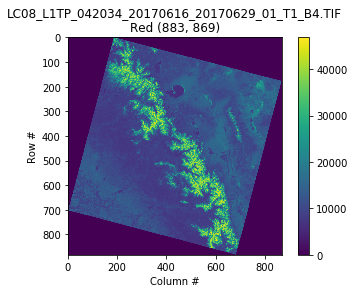

In [6]:
with rasterio.open(url+redband) as src:
    profile = src.profile
    oviews = src.overviews(1) # list of overviews from biggest to smallest
    oview = oviews[1]  # Use second-highest resolution overview
    print('Decimation factor= {}'.format(oview))
    red = src.read(1, out_shape=(1, int(src.height // oview), int(src.width // oview)))
    
plt.imshow(red)
plt.colorbar()
plt.title('{}\nRed {}'.format(redband, red.shape))
plt.xlabel('Column #')
plt.ylabel('Row #')

Text(0,0.5,'Row #')

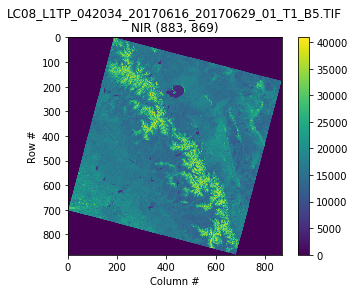

In [7]:
with rasterio.open(url+nirband) as src:
    oviews = src.overviews(1) # list of overviews from biggest to smallest
    oview = oviews[1]  # Use second-highest resolution overview
    nir = src.read(1, out_shape=(1, int(src.height // oview), int(src.width // oview)))
    
plt.imshow(nir)
plt.colorbar()
plt.title('{}\nNIR {}'.format(nirband, nir.shape))
plt.xlabel('Column #')
plt.ylabel('Row #')

In [8]:
def calc_ndvi(nir,red):
    '''Calculate NDVI from integer arrays'''
    nir = nir.astype('f4')
    red = red.astype('f4')
    ndvi = (nir - red) / (nir + red)
    return ndvi

/Users/scott/miniconda3/envs/raster/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in true_divide
  """


Text(0,0.5,'Row #')

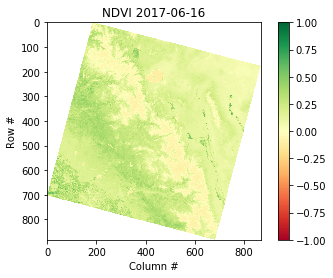

In [9]:
ndvi = calc_ndvi(nir,red)
plt.imshow(ndvi, cmap='RdYlGn')
plt.colorbar()
plt.title('NDVI {}'.format(date))
plt.xlabel('Column #')
plt.ylabel('Row #')

# 4. Save the NDVI raster to local disk
So far, we have read in a cloud-optimized geotiff from the Cloud into our computer memory (RAM), and done a simple computation. What if we want to save this result locally for future use?

Since we have used a subsampled overview, we have to modify the orginal metadata before saving! In particular, the Affine matrix describing the coordinates is different (new resolution and extents, and we've changed the datatype). We'll stick with Geotiff, but note that it is no longer cloud-optimized.

In [10]:
localname = 'LC08_L1TP_042034_20170616_20170629_01_T1_NDVI_OVIEW.tif'

with rasterio.open(url+nirband) as src:
    profile = src.profile.copy()
    
    aff = src.transform
    newaff = rasterio.Affine(aff.a * oview, aff.b, aff.c,
                             aff.d, aff.e * oview, aff.f)
    profile.update({
            'dtype': 'float32',
            'height': ndvi.shape[0],
            'width': ndvi.shape[1],
            'transform': newaff})  
    
    with rasterio.open(localname, 'w', **profile) as dst:
        dst.write_band(1, ndvi)

{'driver': 'GTiff', 'dtype': 'float32', 'nodata': None, 'width': 869, 'height': 883, 'count': 1, 'crs': CRS({'init': 'epsg:32611'}), 'transform': Affine(270.0, 0.0, 204285.0,
       0.0, -270.0, 4268115.0), 'blockxsize': 512, 'blockysize': 512, 'tiled': True, 'compress': 'deflate', 'interleave': 'band'}


Text(0,0.5,'Row #')

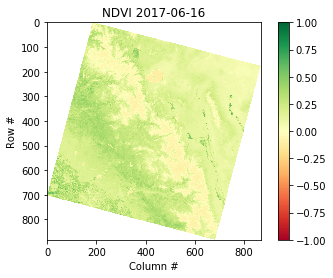

In [11]:
# Reopen the file and plot
with rasterio.open(localname) as src:
    print(src.profile)
    ndvi = src.read(1) # read the entire array

plt.imshow(ndvi, cmap='RdYlGn')
plt.colorbar()
plt.title('NDVI {}'.format(date))
plt.xlabel('Column #')
plt.ylabel('Row #')

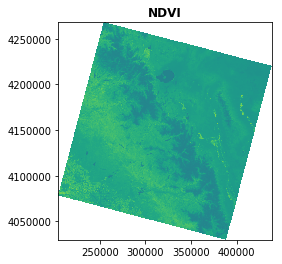

In [12]:
# Rasterio also has a 'convenience method' for plotting with georeferenced coordinates
# in this case, coordinates are Easting [m] and Northing [m], and colorbar is default instead of RdYlGn
with rasterio.open(localname) as src:
    fig, ax = plt.subplots()
    rasterio.plot.show(src, ax=ax, title='NDVI') 

## Spatial indexing and extracting values
Raster images really have two sets of coordinates. First, 'image coordinates' correspond to the row and column for a specific pixel. Second, the 'spatial coordinates' correspond to the location of each pixel on the surface of the Earth. Rasterio makes it convenient to use both coordinate systems.

Lets say you want the value of NDVI at a specific point in this scene. For example Fresno, CA (-119.770163586, 36.741997032). But the image is in UTM coordinates, so you have to first convert these points to UTM (Many websites will do this for you https://www.geoplaner.com), or you can use the pyproj library. Be warned that this only works if you read the dataset at it's full resolution (if you do decimated or windowed reads of the file, you need to adjust the affine transform).

In [13]:
with rasterio.open(localname) as src:
    # Use pyproj to convert point coordinates
    utm = pyproj.Proj(src.crs) # Pass CRS of image from rasterio
    lonlat = pyproj.Proj(init='epsg:4326')

    lon,lat = (-119.770163586, 36.741997032)
    east,north = pyproj.transform(lonlat, utm, lon, lat)

    print('Fresno NDVI\n-------')
    print(f'lon,lat=\t\t({lon:.2f},{lat:.2f})')
    print(f'easting,northing=\t({east:g},{north:g})')

    # What is the corresponding row and column in our image?
    row, col = src.index(east, north) # spatial --> image coordinates
    print(f'row,col=\t\t({row},{col})')

    # What is the NDVI?
    value = ndvi[row, col]
    print(f'ndvi=\t\t\t{value:.2f}')


    # Or if you see an interesting feature and want to know the spatial coordinates:
    row, col = 200, 450
    east, north = src.xy(row,col) # image --> spatial coordinates
    lon,lat = pyproj.transform(utm, lonlat, east, north)
    value = ndvi[row, col]
    print(f'''
Interesting Feature
-------
row,col=          ({row},{col})
easting,northing= ({east:g},{north:g})
lon,lat=          ({lon:.2f},{lat:.2f})
ndvi=              {value:.2f}
''')

Fresno NDVI
-------
lon,lat=		(-119.77,36.74)
easting,northing=	(252664,4.06983e+06)
row,col=		(734,179)
ndvi=			0.24

Interesting Feature
-------
row,col=          (200,450)
easting,northing= (325920,4.21398e+06)
lon,lat=          (-118.98,38.06)
ndvi=              -0.10



# 5. Calculate change in NDVI over time

Let's take a look at the difference in NDVI between a scene in June 2013 and June 2017. If you went to the [AWS Landsat Archive page](https://registry.opendata.aws/landsat-8), you probably noticed that it isn't obvious how to search and discover images (most of the time you probably won't know the row, path, or full URL of images over your area of interest!) There are many options for searching, graphical web applications like [NASA's Earthdata Search](https://search.earthdata.nasa.gov), or convenient Python tools like DevSeed's [sat-search](https://github.com/sat-utils/sat-search), among many others! We won't go into these tools here, but we encourage you to experiment with your own image scenes. Here is a file from June 2018 that was easy to find with Landsat for AWS using the Path and Row from the earlier URL:

https://landsatonaws.com/L8/042/034/LC08_L1TP_042034_20180619_20180703_01_T1

With the band 4 imagery URL:

http://landsat-pds.s3.amazonaws.com/c1/L8/042/034/LC08_L1TP_042034_20180619_20180703_01_T1/LC08_L1TP_042034_20180619_20180703_01_T1_B4.TIF

In [14]:
# Use the same example image:
date2 = '2018-06-19'
url2 = 'http://landsat-pds.s3.amazonaws.com/c1/L8/042/034/LC08_L1TP_042034_20180619_20180703_01_T1/'
redband2 = 'LC08_L1TP_042034_20180619_20180703_01_T1_B{}.TIF'.format(4)
nirband2 = 'LC08_L1TP_042034_20180619_20180703_01_T1_B{}.TIF'.format(5)

In [15]:
filepath = url2+redband2
with rasterio.open(filepath) as src:
    print('Opening:', filepath)
    oviews = src.overviews(1) # list of overviews from biggest to smallest
    oview = oviews[1]  # Use second-highest resolution overview
    print('Decimation factor= {}'.format(oview))
    red2 = src.read(1, out_shape=(1, int(src.height // oview), int(src.width // oview)))

filepath = url2+nirband2
with rasterio.open(filepath) as src:
    print('Opening:', filepath)
    oviews = src.overviews(1) # list of overviews from biggest to smallest
    oview = oviews[1]  # Use second-highest resolution overview
    print('Decimation factor= {}'.format(oview))
    nir2 = src.read(1, out_shape=(1, int(src.height // oview), int(src.width // oview)))

ndvi2 = calc_ndvi(nir2, red2)

Opening: http://landsat-pds.s3.amazonaws.com/c1/L8/042/034/LC08_L1TP_042034_20180619_20180703_01_T1/LC08_L1TP_042034_20180619_20180703_01_T1_B4.TIF
Decimation factor= 9
Opening: http://landsat-pds.s3.amazonaws.com/c1/L8/042/034/LC08_L1TP_042034_20180619_20180703_01_T1/LC08_L1TP_042034_20180619_20180703_01_T1_B5.TIF
Decimation factor= 9


/Users/scott/miniconda3/envs/raster/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in true_divide
  """


Text(0.5,1,'Diff (2018-06-19 - 2017-06-16)')

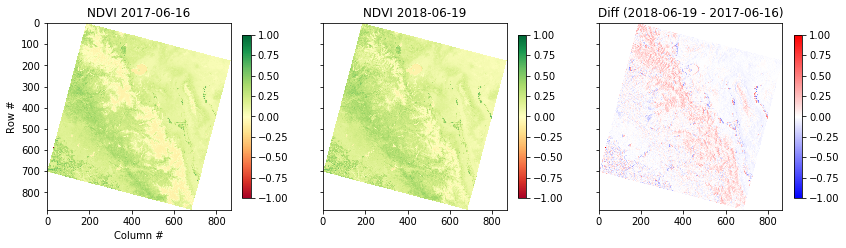

In [16]:
fig, axes = plt.subplots(1,3, figsize=(14,6), sharex=True, sharey=True)

plt.sca(axes[0])
plt.imshow(ndvi, cmap='RdYlGn', vmin=-1, vmax=1)
plt.colorbar(shrink=0.5)
plt.title('NDVI {}'.format(date))
plt.xlabel('Column #')
plt.ylabel('Row #')

plt.sca(axes[1])
plt.imshow(ndvi2, cmap='RdYlGn', vmin=-1, vmax=1)
plt.colorbar(shrink=0.5)
plt.title('NDVI {}'.format(date2))

plt.sca(axes[2])
plt.imshow(ndvi2 - ndvi, cmap='bwr', vmin=-1, vmax=1)
plt.colorbar(shrink=0.5)
plt.title('Diff ({} - {})'.format(date2, date))

### What just happened?

We just loaded 4 decimated Landsat 8 band images into memory and computed the difference in NDVI between two dates. That was relatively easy because the Tier 1 Landsat 8 images are on the exact same grid and use the same reference frame. This is know as 'Analysis Ready Data'. In the geosciences, we commonly have data in WGS84 Lat, Lon. Or what if you want to compare to NDVI estimated from Sentinel-2 satellite acquisitions, which are on a different grid? 

# 6. Advanced uses of rasterio 

Rasterio can also be used for masking, reprojecting, and regridding distinct datasets. Here is one simple example to reproject our local NDVI onto a WGS84 Lat/Lon Grid. The example creates a 'VRT' file, which is merely a ASCII text file describing the transformation and other image metadata. The array values do no need to be duplicated, the VRT file just contains a reference to the local file (LC08_L1TP_042034_20170616_20170629_01_T1_NDVI_OVIEW.tif). This is extremely useful to avoid duplicating lots of data and filling up your computer!

In [17]:
import rasterio.warp
import rasterio.shutil

In [18]:
localname = 'LC08_L1TP_042034_20170616_20170629_01_T1_NDVI_OVIEW.tif'
vrtname = 'LC08_L1TP_042034_20170616_20170629_01_T1_NDVI_OVIEW_WGS84.vrt'

with rasterio.open(localname) as src:
    with rasterio.vrt.WarpedVRT(src, crs='epsg:4326', resampling=rasterio.enums.Resampling.bilinear) as vrt:
        rasterio.shutil.copy(vrt, vrtname, driver='VRT')

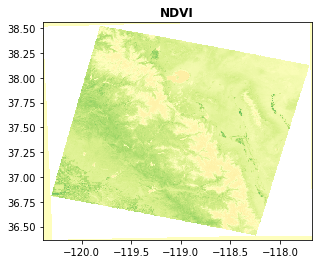

In [19]:
# NOTE our coordinates have changed to lat, lon. we should probably crop the edge artifacts do to reprojection too!
with rasterio.open(vrtname) as src:
    rasterio.plot.show(src, title='NDVI', cmap='RdYlGn', vmin=-1, vmax=1)

The issue with VRTs is now you have two files and let's say you want to share this image with a colleague. Also if you move things around on your computer, the paths might get mixed up, so in some cases it's nice to save a complete reprojected file. The second code block does this, saving our NDVI as a Geotiff in WGS84.

In [20]:
localname = 'LC08_L1TP_042034_20170616_20170629_01_T1_NDVI_OVIEW.tif'
tifname = 'LC08_L1TP_042034_20170616_20170629_01_T1_NDVI_OVIEW_WGS84.tif'

dst_crs = 'EPSG:4326'

with rasterio.open(localname) as src:
    profile = src.profile.copy()
    
    transform, width, height = rasterio.warp.calculate_default_transform(
        src.crs, dst_crs, src.width, src.height, *src.bounds)
    
    profile.update({
        'crs': dst_crs,
        'transform': transform,
        'width': width,
        'height': height
    })
    
    with rasterio.open(tifname, 'w', **profile) as dst:
        rasterio.warp.reproject(
            source=rasterio.band(src, 1),
            destination=rasterio.band(dst, 1),
            src_transform=src.transform,
            src_crs=src.crs,
            dst_transform=transform,
            dst_crs=dst_crs,
            resampling=rasterio.warp.Resampling.bilinear)

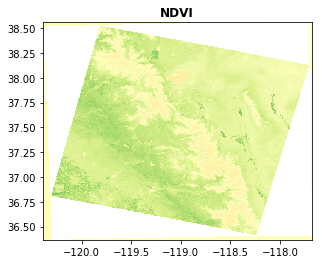

In [21]:
# NOTE our coordinates have changed to lat, lon. we should probably crop the edge artifacts do to reprojection too!
with rasterio.open(tifname) as src:
    rasterio.plot.show(src, title='NDVI', cmap='RdYlGn', vmin=-1, vmax=1)

# Additional resources

This just scratches the surface of what you can do with rasterio. Check out the excellent official documentation as you continue exploring:

https://rasterio.readthedocs.io/en/latest/